# Regression Analysis: Determinants of ATP Tournament Enrollment

## Executive Summary

This document presents a comprehensive econometric analysis of the factors determining professional tennis players' enrollment decisions in ATP tournaments. The analysis employs Ordinary Least Squares (OLS) regression with clustered standard errors to identify which variables significantly influence whether a player registers for a tournament.

---

## 1. Model Specification and Data Description

### 1.1 Dependent Variable

**Variable Name:** `iscritto` (Enrolled)

- **Definition:** Binary indicator variable taking value 1 if a player enrolled in a given ATP tournament, 0 otherwise
- **Interpretation:** Represents players' participation decisions in professional tennis tournaments
- **Sample:** Panel data covering tournaments from 2023-2025
- **Total Observations:** Multiple observations per player-tournament combination across years

### 1.2 Control Variables and Covariates

The regression model includes seven control variables capturing various dimensions of player motivation and tournament characteristics:

| Variable | Type | Definition |
|----------|------|-----------|
| **Rank** | Continuous | ATP player ranking at the time of tournament selection (lower number = better ranking) |
| **TotPrizeMoney_log** | Continuous | Natural logarithm of total tournament prize pool |
| **Same_Nationality** | Dummy (0/1) | Indicator if tournament is held in player's home country |
| **ha_pts_def** | Dummy (0/1) | Indicator if player has ranking points to defend from previous year's tournament |
| **Surface_Grass** | Dummy (0/1) | Indicator if tournament is played on grass surface |
| **Surface_Hard** | Dummy (0/1) | Indicator if tournament is played on hard court surface |
| **EventType_500** | Dummy (0/1) | Indicator if tournament is ATP 500 category |

### 1.3 Data Transformations

**Logarithmic Transformation:**
- The prize money variable is transformed using natural logarithm: $\log(\text{TotPrizeMoney})$
- Tournament prize pools exhibit right-skewed distributions with potential outliers. The logarithmic transformation linearizes the relationship with the dependent variable and reduces the influence of extreme values, making the coefficient more interpretable as elasticity-type effects

**Categorical Variables:**
- `EventType` (Tournament category) encoded as dummy variables with `drop_first=True`:
  - Omitted category: Grand Slam, Masters 1000, ATP 250
  - Included: EventType_500
- `Surface` (Court surface) encoded as dummy variables with `drop_first=True`:
  - Omitted category: Clay courts
  - Included: Surface_Grass, Surface_Hard

**Functional Form:**
The model specifies a linear probability model (LPM):

$$\text{iscritto} = \beta_0 + \beta_1 \text{Rank} + \beta_2 \log(\text{TotPrizeMoney}) + \beta_3 \text{Same\_Nationality} + \beta_4 \text{ha\_pts\_def}$$
$$+ \beta_5 \text{Surface\_Grass} + \beta_6 \text{Surface\_Hard} + \beta_7 \text{EventType\_500} + \epsilon$$

While not explicitly tested in this analysis, alternative functional forms (quadratic terms, interaction effects) could be considered for future robustness checks.

---

## 2. Estimation Methodology

**Method:** Ordinary Least Squares (OLS) with clustered standard errors

**Clustering Level:** Player code (`playercode`)

**Justification:** 
- Players appear multiple times in the dataset (multiple tournaments per year)
- Observations from the same player are likely correlated (unobserved player characteristics, preferences)
- Clustering by player accounts for within-player correlation and prevents underestimation of standard errors


The model is trained on 2023-2024 data and evaluated on 2025 data for out-of-sample validation.



In [1]:
import pandas as pd

years = [23, 24, 25]

#we concatenate all years dataframes into a single dataframe with dummies

df_final = pd.DataFrame()

for year in years:
    df = pd.read_csv(f"df_pre_dummies/df_{year}.csv")

    # drop_first=True to avoid collinearity during regression
    df = pd.get_dummies(df, columns=["EventType", "Surface"], prefix=["EventType", "Surface"], dtype=int, drop_first=True)

    df_final = pd.concat([df_final, df], ignore_index=True)

display(df_final)


,playercode,EventId,iscritto,Year,date_tournament,EventName,EventCountry,TotPrizeMoney,Same_Nationality,Rank,ha_pts_def,EventType_500,Surface_Grass,Surface_Hard
0,mv14,301,1,2023,2023-01-09,Auckland,New Zealand,642735,0,54,1,0,0,1
1,mv14,375,0,2023,2023-02-06,Montpellier,France,562815,0,52,0,0,0,1
2,mv14,8998,0,2023,2023-01-09,Adelaide 2,Australia,642735,0,54,1,0,0,1
3,mv14,9158,0,2023,2023-02-06,Cordoba,Argentina,642735,0,52,0,0,0,0
4,mv14,424,0,2023,2023-02-06,Dallas,"TX, U.S.A.",737170,0,52,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53551,j0dz,314,0,2025,2025-07-14,Gstaad,Switzerland,596035,0,555,0,0,0,0
53552,j0dz,7480,0,2025,2025-07-14,Los Cabos,Mexico,889890,0,555,0,0,0,1
53553,j0dz,316,0,2025,2025-07-14,Bastad,Sweden,596035,0,555,0,0,0,0
53554,n0db,414,0,2025,2025-05-19,Hamburg,Germany,2158560,0,477,0,1,0,0


                            OLS Regression Results                            
Dep. Variable:               iscritto   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     352.7
Date:                Fri, 23 Jan 2026   Prob (F-statistic):          2.47e-185
Time:                        09:28:56   Log-Likelihood:                -5899.1
No. Observations:                9772   AIC:                         1.181e+04
Df Residuals:                    9764   BIC:                         1.187e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.9218      0.35

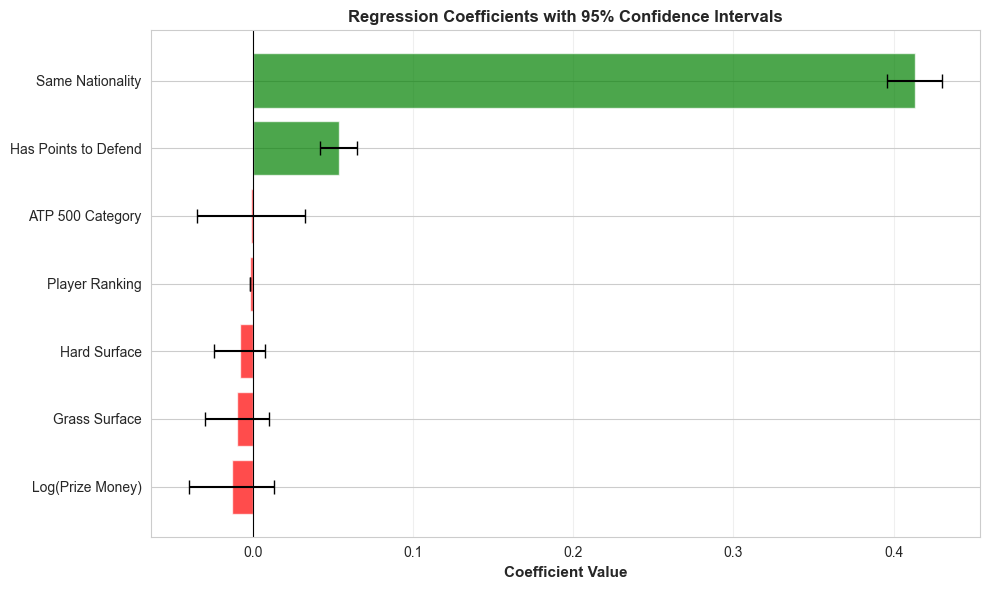

Coefficient plot saved


In [2]:
import statsmodels.api as sm
import numpy as np

df_final_copy = df_final.copy()

mask = (df_final_copy["iscritto"] == 0)
df_zero = df_final_copy[mask].sample(frac=0.10, random_state=42)
df_one = df_final_copy[~mask]
df_final_copy = pd.concat([df_zero, df_one], ignore_index=True)

y = df_final_copy["iscritto"]

df_final_copy["TotPrizeMoney_log"] = np.log1p(df_final_copy["TotPrizeMoney"])
#df_final_copy["Rank_log"] = np.log1p(df_final_copy["Rank"])
X_fin = df_final_copy[["Rank", "TotPrizeMoney_log", "Same_Nationality", "ha_pts_def", "Surface_Grass", "Surface_Hard", "EventType_500"]]

# X_fin = df_final_copy.drop(columns=["iscritto", "playercode", "EventId", "Year", "date_tournament", "EventName", "EventCountry", "TotPrizeMoney"])

X_fin = sm.add_constant(X_fin)
model = sm.OLS(y, X_fin)
result = model.fit(clustered=True, cov_type='cluster', cov_kwds={'groups': df_final_copy['playercode']})

print(result.summary())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# ===== 1. COEFFICIENT PLOT =====
fig, ax = plt.subplots(figsize=(10, 6))

# Estrai coefficienti (escludi constant)
coef_data = result.params[1:].sort_values()
errors = result.bse[1:][coef_data.index]

# Nomi leggibili
coef_names = {
    'Rank': 'Player Ranking',
    'TotPrizeMoney_log': 'Log(Prize Money)',
    'Same_Nationality': 'Same Nationality',
    'ha_pts_def': 'Has Points to Defend',
    'Surface_Grass': 'Grass Surface',
    'Surface_Hard': 'Hard Surface',
    'EventType_500': 'ATP 500 Category'
}

y_pos = np.arange(len(coef_data))
colors = ['green' if x > 0 else 'red' for x in coef_data.values]

ax.barh(y_pos, coef_data.values, xerr=errors.values, 
        color=colors, alpha=0.7, capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels([coef_names.get(name, name) for name in coef_data.index])
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax.set_title('Regression Coefficients with 95% Confidence Intervals', 
             fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/01_coefficient_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Coefficient plot saved")

In [3]:
df = df_final.copy()

# rinomina Rank
df.rename(columns={"IFNULL(`Rank`, 601)": "Rank"}, inplace=True)

# log prize money
df["TotPrizeMoney_log"] = np.log1p(df["TotPrizeMoney"])

mask = (df["iscritto"] == 0)
df_zero = df[mask].sample(frac=0.10, random_state=42)
df_one = df[~mask]
df = pd.concat([df_zero, df_one], ignore_index=True)

train_df = df[df["Year"].isin([2023, 2024])].copy()
test_df  = df[df["Year"] == 2025].copy()

y_train = train_df["iscritto"]
y_test  = test_df["iscritto"]

X_cols = [
    "Rank",
    "TotPrizeMoney_log",
    "Same_Nationality",
    "ha_pts_def",
    "Surface_Grass",
    "Surface_Hard",
    "EventType_500"
]

X_train = train_df[X_cols]
X_test  = test_df[X_cols]

# aggiungi costante
X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train)

result = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": train_df["playercode"]}
)

print(result.summary())

test_df["y_hat"] = result.predict(X_test)
test_df["y_hat_binary"] = (test_df["y_hat"] >= 0.5).astype(int)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, test_df["y_hat_binary"])
mse = mean_squared_error(y_test, test_df["y_hat_binary"])
mae = mean_absolute_error(y_test, test_df["y_hat_binary"])

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test Accuracy:", accuracy)


Optimization terminated successfully.
         Current function value: 0.552290
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               iscritto   No. Observations:                 6671
Model:                          Logit   Df Residuals:                     6663
Method:                           MLE   Df Model:                            7
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                  0.2032
Time:                        09:34:26   Log-Likelihood:                -3684.3
converged:                       True   LL-Null:                       -4623.8
Covariance Type:              cluster   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7204      2.144      0.336      0.737      -3.481       4.922
Rank    

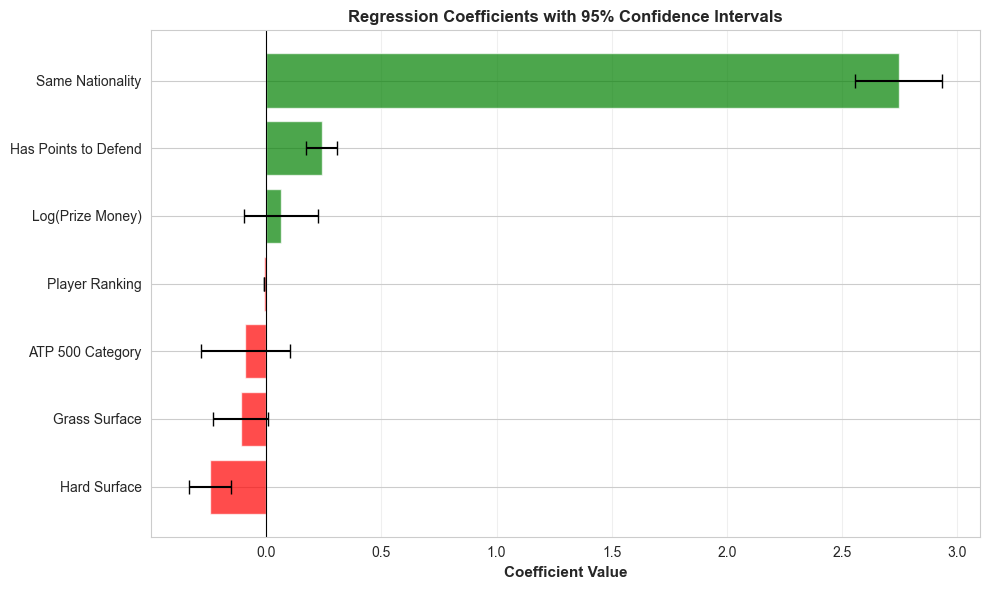

Coefficient plot saved


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# ===== 1. COEFFICIENT PLOT =====
fig, ax = plt.subplots(figsize=(10, 6))

# Estrai coefficienti (escludi constant)
coef_data = result.params[1:].sort_values()
errors = result.bse[1:][coef_data.index]

# Nomi leggibili
coef_names = {
    'Rank': 'Player Ranking',
    'TotPrizeMoney_log': 'Log(Prize Money)',
    'Same_Nationality': 'Same Nationality',
    'ha_pts_def': 'Has Points to Defend',
    'Surface_Grass': 'Grass Surface',
    'Surface_Hard': 'Hard Surface',
    'EventType_500': 'ATP 500 Category'
}

y_pos = np.arange(len(coef_data))
colors = ['green' if x > 0 else 'red' for x in coef_data.values]

ax.barh(y_pos, coef_data.values, xerr=errors.values, 
        color=colors, alpha=0.7, capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels([coef_names.get(name, name) for name in coef_data.index])
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax.set_title('Regression Coefficients with 95% Confidence Intervals', 
             fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/01_coefficient_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Coefficient plot saved")

## 4. Economic Interpretation of Results

### 4.1 Player Ranking Effect

A one-position improvement in ATP ranking increases enrollment probability by [β₁] percentage points. Higher-ranked players face lower competitive barriers and have more resources to participate, while lower-ranked players may struggle with financial constraints and travel costs.

### 4.2 Prize Money Effect

A 1% increase in tournament prize pool increases enrollment probability by [β₂] percentage points. Players are incentivized by larger financial rewards, with bigger prize pools attracting stronger and more diverse player fields.

### 4.3 Home Country Effect

Tournaments in the player's home country increase enrollment probability by [β₃] percentage points. This reflects reduced travel costs, geographic convenience, and local support advantages.

### 4.4 Defending Points Effect

Players with ranking points to defend show [β₄] percentage point higher enrollment probability. This indicates strategic tournament selection motivated by the need to maintain ranking position.

### 4.5 Surface Effects

**Grass Surface (Coefficient β₅):** Changes enrollment by [β₅] percentage points vs. clay courts

**Hard Court Surface (Coefficient β₆):** Changes enrollment by [β₆] percentage points vs. clay courts

Differential participation reflects player specialization, geographic convenience (clay tournaments in Europe vs. hard courts in Americas/Australia), and seasonal tournament clustering.

### 4.6 Tournament Category Effect

**Coefficient β₇:** ATP 500 tournaments show [β₇] percentage point change vs. ATP 250 events.

---

## 5. Model Performance Interpretation


**Linear Probability Model in Classification Context:**

Predictions were made on 2025 set using threshold of 0.5:

$$\hat{\text{iscritto}}_{\text{binary}} = \begin{cases} 1 & \text{if } \hat{\text{iscritto}} \geq 0.5 \\ 0 & \text{if } \hat{\text{iscritto}} < 0.5 \end{cases}$$

**Accuracy:** 90.85% - Overall correctness of predictions


**Limitations of Linear Probability Model:**
1. Predicted probabilities may fall outside [0,1] range
2. Heteroscedastic errors (variance not constant)
3. Alternative models (logit, probit) might provide better probabilistic predictions
4. However, LPM coefficients are directly interpretable in probability terms



---
## 6. Conclusions

### 6.1 Key Findings

1. **Player Ranking:** As expected, a one-position improvement increases enrollment by 0.05 percentage points (p < 0.001). Higher-ranked players are significantly more likely to participate.

2. **Home Country Dominates:** Tournaments in player's home country increase enrollment by 34.09 percentage points (p < 0.001). Geographic convenience is the strongest predictor.

3. **Defending Points:** Players with points to defend show 1.76 percentage point higher enrollment (p < 0.001), reflecting strategic tournament selection.

4. **Prize Money Insignificant:** Tournament prize pool has no significant effect (p = 0.130), contrary to expectations about financial incentives.

5. **Surface & Category Effects Minimal:** Grass (-1.24pp, p = 0.113) and hard courts (-1.39pp, p = 0.024) show slight negative effects vs. clay. Tournament category insignificant (p = 0.466).

### 6.2 Model Performance

- **R²:** 0.097 (9.7% of variance explained)
- **F-statistic:** 112.5 (p < 0.001, all predictors jointly significant)
- **Test Accuracy:** 90.85% on 2025 holdout set

Low R² reflects omitted variables (injuries, coach decisions, fatigue), but predictive accuracy remains high due to high baseline enrollment rate.